# Energy profile vs. beam intensity

To do: check whether the mean x and y on the BPM is the same at each intensity.

In [1]:
import os
from os.path import join
from collections import Counter
from datetime import datetime
import h5py
import numpy as np
from tqdm import trange
from scipy import optimize as opt
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import proplot as pplt

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'

In [2]:
folder = 'Diagnostics/Data/Measurements/2022-04-27/'
filenames = os.listdir(folder)
filenames = sorted(filenames, key=lambda filename: int(filename.split('-')[0]))
filenames

['220427143259-image_on_demand.h5',
 '220427151311-y1d-vs06.h5',
 '220427151929-y1d-vs06.h5',
 '220427152517-x2d-slit.h5',
 '220427155227-x2d-slit.h5',
 '220427163645-x2d-slit.h5',
 '220427170354-x2d-slit.h5']

In [3]:
filename = filenames[0]
file = h5py.File(join(folder, filename), 'r')
list(file.keys())

['config', 'log', 'scandata']

In [4]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

04/27/2022, 14:33:15 b'Ctrl-C pressed, will exit after current iteration is complete. Press Ctrl-C again to exit immediately.'
environment
--------------
timestamp: [1.65108438e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'misc/image_on_demand.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.6510844e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [2.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.0999999]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.30000019]
BTF_MEBT_Mag:PS

In [5]:
data = file['scandata']
print('Data:')
for i, name in enumerate(data.dtype.names):
    print(f'{name} [{data.dtype[i]}]')
print()

slits = [key for key in data.dtype.names if 'PositionSync' in key]
print('slits:')
for slit in slits:
    print(slit)

Data:
timestamp [float64]
iteration [int64]
bcm [float64]
cam06_Image [('<i4', (313344,))]
cam06_ProfileX [('<f4', (612,))]
cam06_Saturation [float64]
ITSF_Diag:Slit_VT04:PositionSync [float64]
ITSF_Diag:Slit_VT06:PositionSync [float64]
ITSF_Diag:Slit_HZ06:PositionSync [float64]
bpm04_x [('<f8', (1200,))]
bpm04_y [('<f8', (1200,))]
bpm04_magu [('<f4', (1200,))]
bpm04_magd [('<f4', (1200,))]
bpm04_magl [('<f4', (1200,))]
bpm04_magr [('<f4', (1200,))]
cam06_exp [int32]
focus2 [float64]
focus1 [float64]
x_PositionSync [float64]

slits:
ITSF_Diag:Slit_VT04:PositionSync
ITSF_Diag:Slit_VT06:PositionSync
ITSF_Diag:Slit_HZ06:PositionSync
x_PositionSync


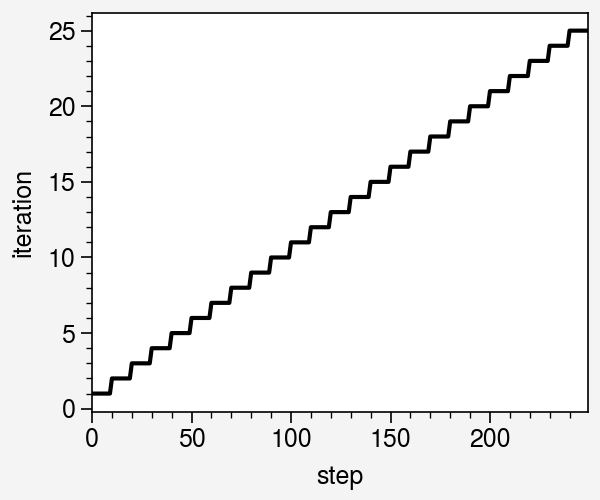

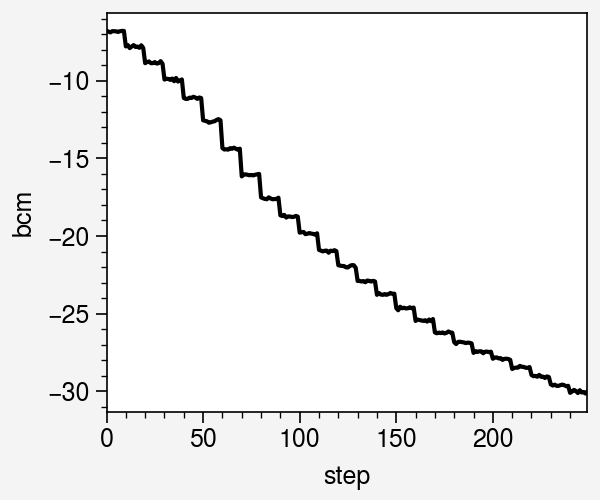

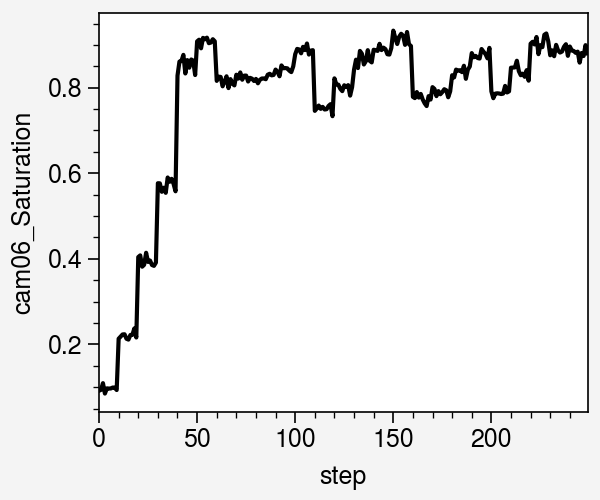

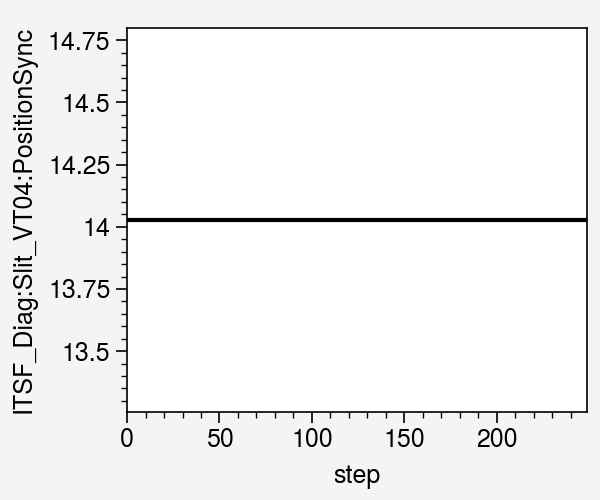

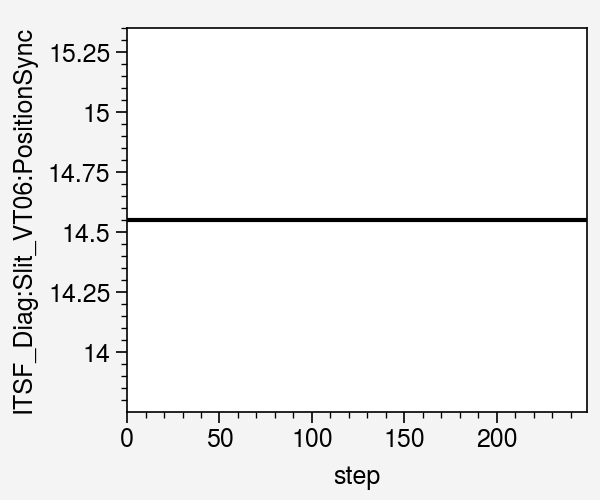

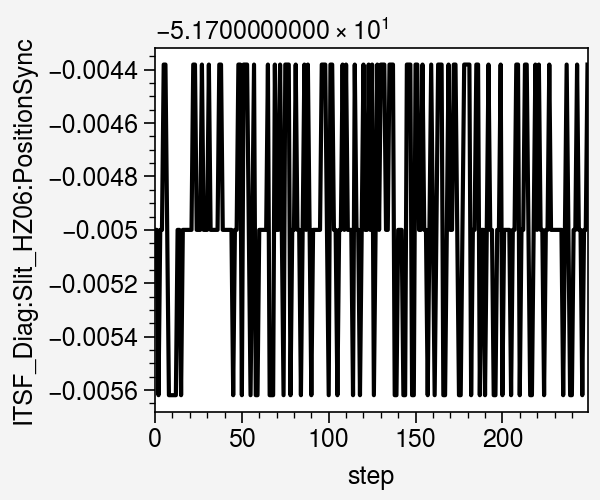

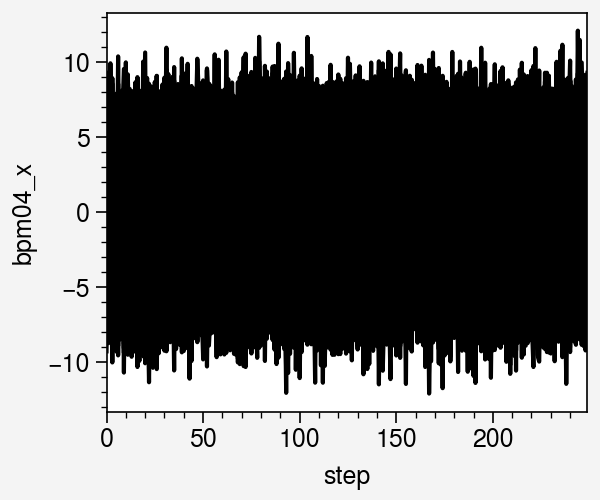

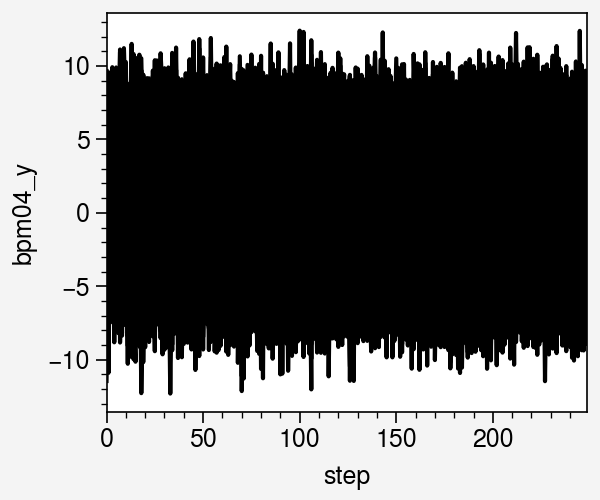

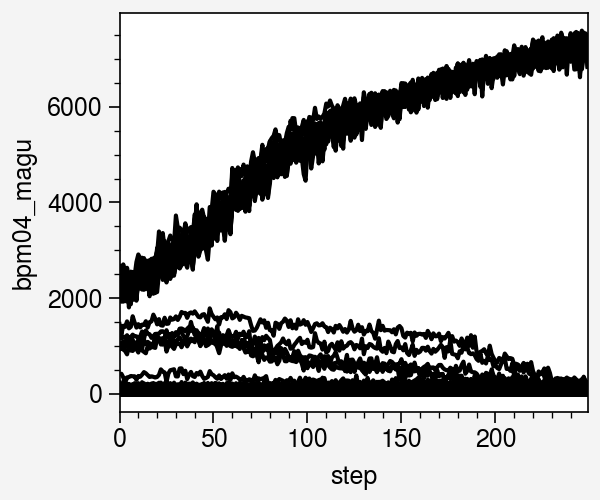

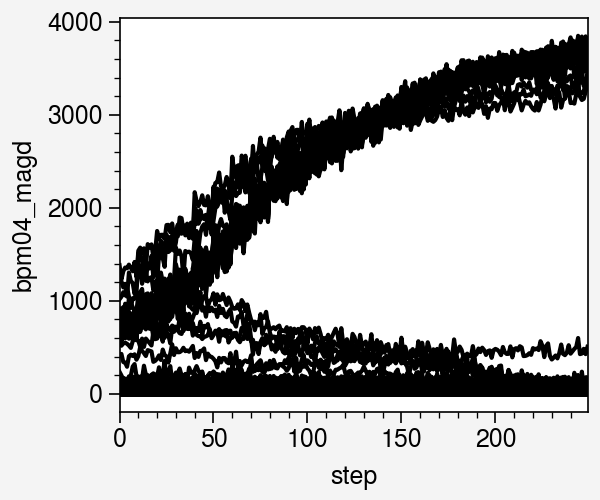

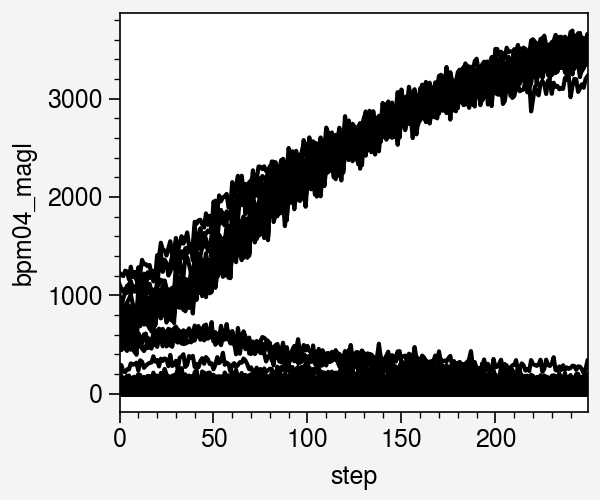

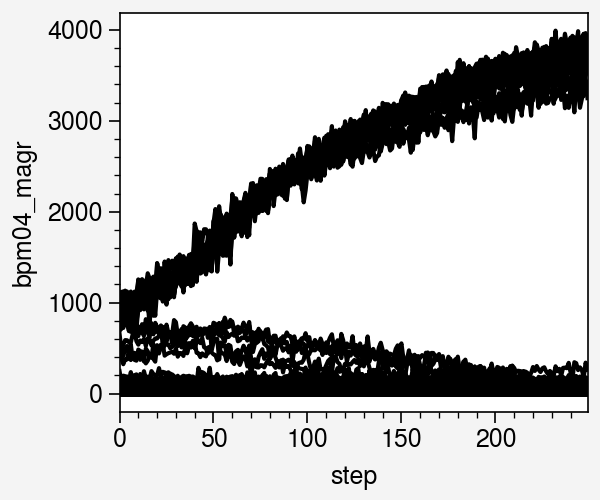

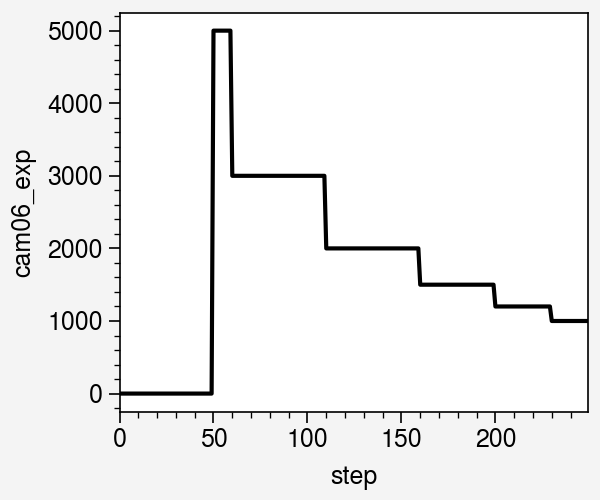

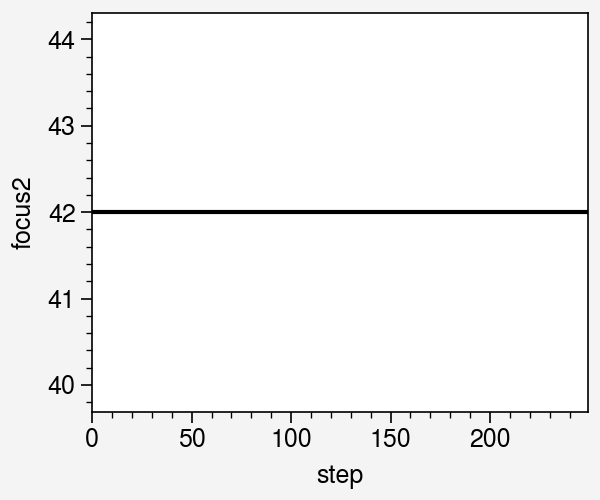

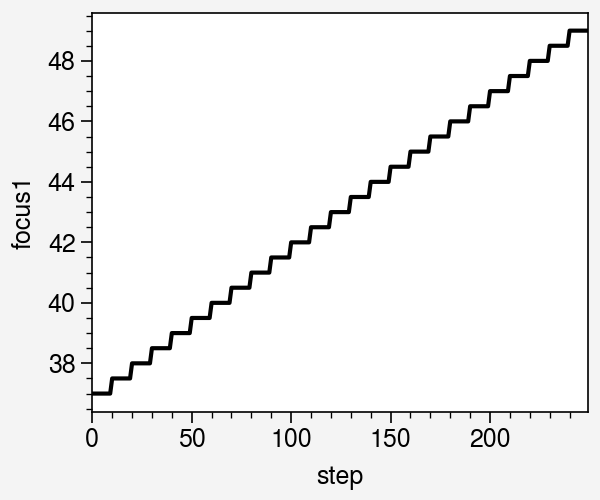

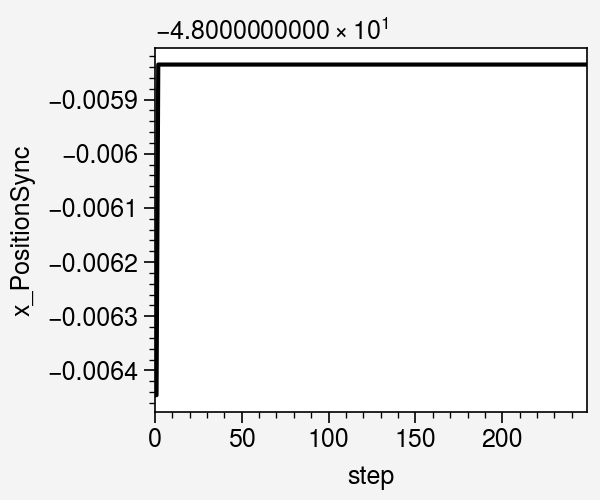

In [6]:
for name in data.dtype.names:
    if name in ['timestamp', 'cam06_Image', 'cam06_ProfileX']:
        continue
    fig, ax = pplt.subplots(figsize=(3.0, 2.5))
    ax.plot(data[name], color='black')
    ax.format(xlabel='step', ylabel=name)
    plt.show()

{'ycolor': 'grey'}


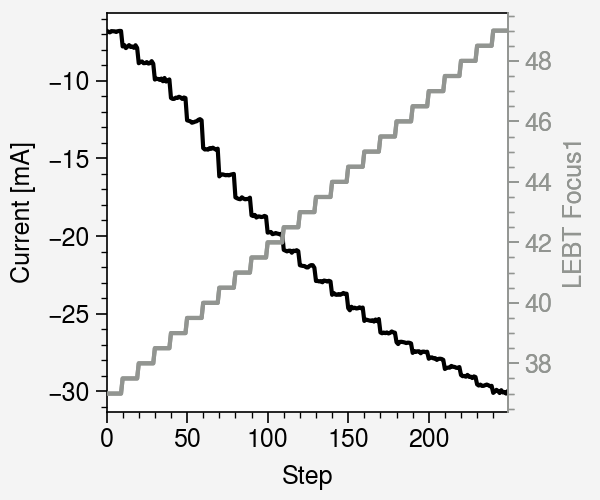

In [7]:
fig, ax = pplt.subplots(figsize=(3.0, 2.5))
ax.format(xlabel='Step', ylabel='Current [mA]')
ax2 = ax.alty(color='grey')
ax2.format(ylabel='LEBT Focus1')
ax2.plot(data['focus1'], color='grey')
ax.plot(data['bcm'], color='black')
plt.savefig('_output/current')

In [8]:
bpm_wfs = dict()
bpm_means = dict()
bpm_stds = dict()
bpm_keys = ['x', 'y', 'u', 'd', 'l', 'r', 'xraw', 'yraw']
for key in bpm_keys:
    bpm_wfs[key] = []
    bpm_means[key] = []
    bpm_stds[key] = []

In [9]:
iterations = []
profiles = []
currents = []
images = []
lo, hi = 566, 595
for iteration in trange(1, max(data['iteration']) + 1):
    iterations.append(iteration)
    idx = data['iteration'] == iteration
    image = np.mean(data['cam06_Image'][idx, :], axis=0).reshape((512, 612))
    images.append(image)
    profile = np.mean(data['cam06_ProfileX'][idx, :], axis=0)  # averagine
    profile = profile / np.sum(profile)  # normalize
    profiles.append(profile)
    currents.append(data['bcm'][idx][0])
    # BPM waveforms
    cut = 999  # some waveforms are zero beyond this index
    bpm_wf = dict()
    bpm_wf['x'] = np.mean(data['bpm04_x'][idx, :cut], axis=0)
    bpm_wf['y'] = np.mean(data['bpm04_y'][idx, :cut], axis=0)
    bpm_wf['u'] = np.mean(data['bpm04_magu'][idx, :cut], axis=0)
    bpm_wf['d'] = np.mean(data['bpm04_magd'][idx, :cut], axis=0)
    bpm_wf['l'] = np.mean(data['bpm04_magl'][idx, :cut], axis=0)
    bpm_wf['r'] = np.mean(data['bpm04_magr'][idx, :cut], axis=0)
    bpm_wf['xraw'] = 8.0 * np.log10(bpm_wf['l'] / bpm_wf['r'])
    bpm_wf['yraw'] = 8.0 * np.log10(bpm_wf['u'] / bpm_wf['d'])
    for key, wf in bpm_wf.items():
        window = wf[lo:hi]
        bpm_means[key].append(np.mean(window))
        bpm_stds[key].append(np.std(window))
        bpm_wfs[key].append(wf)

100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


In [10]:
profiles = np.array(profiles)
currents = np.array(currents)
for key in bpm_wfs:
    bpm_wfs[key] = np.array(bpm_wfs[key])
    bpm_means[key] = np.array(bpm_means[key])
    bpm_stds[key] = np.array(bpm_stds[key])

The following cell creates a lot of plots.

In [11]:
pad = 25
_lo = lo - pad
_hi = hi + pad
xx = np.arange(lo - pad, hi + pad)
# for i in range(len(profiles)):
#     fig, axes = pplt.subplots(ncols=8, figheight=1.5, sharey=False)
#     plot_kws = dict(color='black')
#     for ax, key in zip(axes, bpm_keys):
#         ax.plot(xx, bpm_wfs[key][i, _lo:_hi], **plot_kws)
#         ax.set_title(key)
#         ax.axvspan(lo, hi, color='black', alpha=0.05)
#     plt.show()

In [15]:
# cmap = pplt.Colormap('greys', left=0.12, right=0.9)
cmap = pplt.Colormap('mono', left=0.05, right=0.9)
norm = colors.Normalize(np.min(np.abs(currents)), np.max(np.abs(currents)))
mappable = cm.ScalarMappable(norm, cmap)

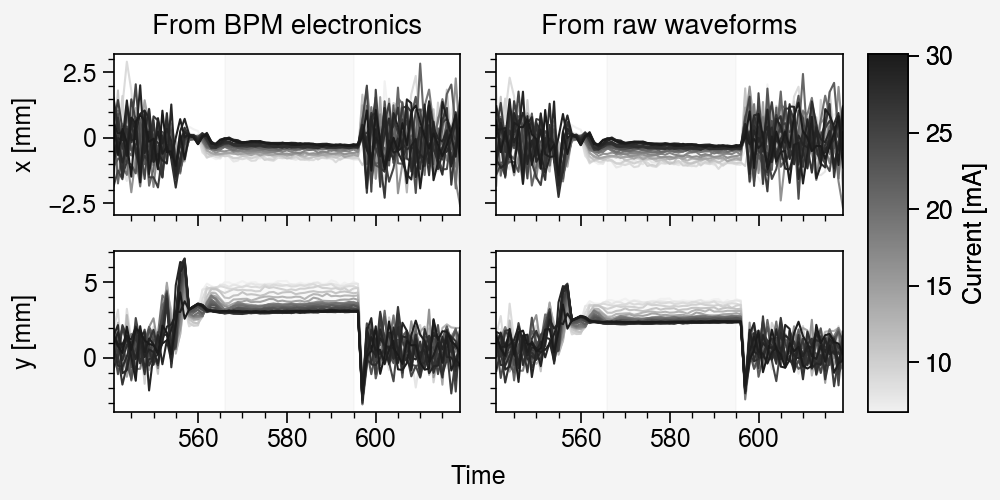

In [16]:
fig, axes = pplt.subplots(ncols=2, nrows=2, figsize=(5, 2.5), spany=False, aligny=True)
plot_kws = dict(lw=0.75)
for i in range(len(profiles)):
    color = mappable.to_rgba(np.abs(currents[i]))
    axes[0, 0].plot(xx, bpm_wfs['x'][i, _lo:_hi].T, color=color, **plot_kws)
    axes[1, 0].plot(xx, bpm_wfs['y'][i, _lo:_hi].T, color=color, **plot_kws)
    axes[0, 1].plot(xx, bpm_wfs['xraw'][i, _lo:_hi].T, color=color, **plot_kws)
    axes[1, 1].plot(xx, bpm_wfs['yraw'][i, _lo:_hi].T, color=color, **plot_kws)
for ax in axes:
    ax.axvspan(lo, hi, color='black', alpha=0.025)
fig.colorbar(mappable, label='Current [mA]')
axes[0, :].format(ylabel='x [mm]')
axes[1, :].format(ylabel='y [mm]')
axes.format(
    xlabel='Time', 
    toplabels=['From BPM electronics', 'From raw waveforms'], 
    toplabels_kw=dict(fontweight='normal'),
)
plt.savefig('_output/bpm')

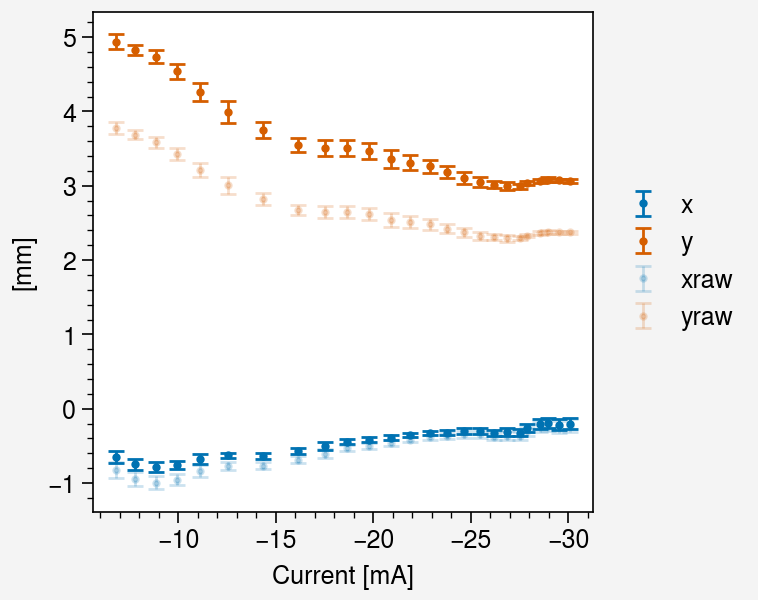

In [18]:
fig, ax = pplt.subplots()
plot_kws = dict(marker='.', ms=4.0, lw=0, elinewidth=1.0)
for key in ['x', 'y']:
    ax.errorbar(currents, bpm_means[key], yerr=bpm_stds[key], label=key, **plot_kws)
ax.format(cycle='colorblind')
plot_kws['alpha'] = 0.2
for key in ['xraw', 'yraw']:
    ax.errorbar(currents, bpm_means[key], yerr=bpm_stds[key], label=key, **plot_kws)
ax.format(xlabel='Current [mA]', ylabel='[mm]')
ax.legend(loc='right', ncols=1, framealpha=0.)
plt.savefig('_output/bpmavg')
plt.show()

Convert screen coordinates to energy.

VS13:

At x0.33 zoom: 0.069 mm/pixel \
At x0.50 zoom: 0.046 mm/pixel \
At x1.00 zoom: 0.023 mm/pixel

In [84]:
# Pixels to mm
pix2mm = 0.046
nx = 612
x3 = pix2mm * np.arange(nx) 

# -- matrix params
a2mm = 1.009  # assume same as first dipole
rho = 0.3556
GL05 = 0
GL06 = 0.0
l1 = 0
l2 = 0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for 1st and last dipole/screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

from tools import energyVS06 as energy
ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)

#Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM2()  # 2nd-slit to screen

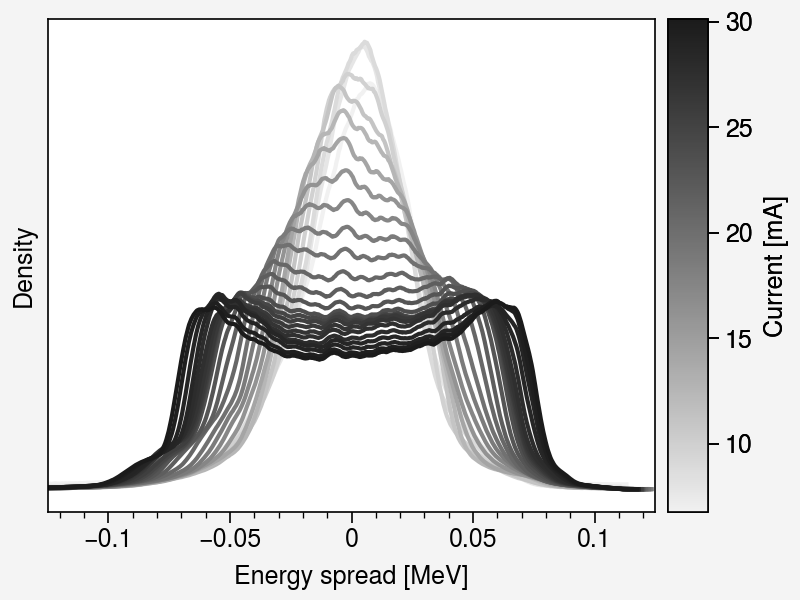

In [94]:
fig, ax = pplt.subplots(figsize=(4.0, 3.0))
for profile, current in zip(profiles, currents):
    # Assume x = x' = 0. Dipole current should be the same as default.
    xavg = np.average(x3, weights=profile)
    w = ecalc.calculate_dE_screen((x3 - xavg) * 1e-3, 0, 0, 0, Mscreen) * 1e3  # energy spread
    ax.plot(w / 1000.0, profile, color = mappable.to_rgba(np.abs(current)))
ax.colorbar(mappable=mappable, label='Current [mA]')
ax.format(yticks=[], xlabel='Energy spread [MeV]', ylabel='Density', xlim=(-0.125, 0.125))
plt.savefig('_output/hollow')

In [ ]:
fig, ax = pplt.subplots(figsize=(5.0, 2.0))
ax.pcolormesh(
    np.arange(profiles.shape[1]),
    currents, 
    profiles, 
    cmap='mono_r', colorbar=True, colorbar_kw=dict(ticks=[]),
)
ax.format(ylabel='Current [mA]', xlabel=r'~$\Delta$E')
plt.savefig('waterfall_heatmap')
plt.show()

In [ ]:
fig, axes = pplt.subplots(nrows=4, ncols=5, figwidth=7.0, space=0.5)
for ax in axes[-2:]:
    ax.axis('off')
for image, ax, current in zip(images[1:], axes, currents):
    ax.imshow(image, cmap='mono_r')
    ax.annotate(f'I = {current:.2f}', xy=(0.01, 0.01), xycoords='axes fraction',
                color='white', fontsize='small',
                verticalalignment='bottom', horizontalalignment='left')
axes.format(xticks=[], yticks=[])
plt.savefig('_output/images')
plt.show()

In [ ]:
# import gif
# gif.options.matplotlib["dpi"] = 200

# @gif.frame
# def plot(i):
#     fig, ax = plt.subplots(figsize=(3.0, 3.0))
#     ax.imshow(images[i], cmap=pplt.Colormap('mono_r', left=0.04))
#     ax.annotate(f'I = {currents[i]:.2f} [mA]', xy=(0.01, 0.01), xycoords='axes fraction',
#                 color='white', fontsize='small',
#                 verticalalignment='bottom', horizontalalignment='left')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.savefig(f'_output/folder/image{i}.png')

# frames = [plot(i) for i in range(len(images))]
# gif.save(frames, '_output/images.gif', duration=0.25, unit="s", between="frames")